# BYOL Merger Classification Analysis

Clean, refactored notebook for analyzing BYOL embeddings and classifying galaxy mergers.

This notebook:
1. Loads trained BYOL model and embeddings
2. Applies PCA and UMAP dimensionality reduction
3. Performs K-NN based label propagation
4. Identifies merger candidates
5. Creates visualizations and analysis plots

## Setup and Imports

In [2]:
import os
os.chdir('/Users/kadofong/work/projects/merian/pieridae/merger_analysis/notebooks')

In [3]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add pieridae to path
sys.path.insert(0, str(Path.cwd().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import pickle
from tqdm import tqdm

from pieridae.starbursts.byol import (
    BYOLModelManager,
    EmbeddingAnalyzer,
    LabelPropagation,
    load_merian_images
)

# Plotting utilities
from ekfstats import sampling
from ekfplot import plot as ek, colors as ec
from matplotlib import colors

print("✅ Imports complete")

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


✅ Imports complete


## Load Configuration

In [223]:
# Load config
config_path = '../config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

config['data']['input_path'] = Path(config['data']['input_path'])
config['data']['output_path'] = Path('../output/fiducial/') #Path(config['data']['output_path'])

print(f"📋 Configuration loaded")
print(f"   Input: {config['data']['input_path']}")
print(f"   Output: {config['data']['output_path']}")

📋 Configuration loaded
   Input: ../../local_data/pieridae_output/starlet/msorabove_v0
   Output: ../output/fiducial


## Load Data and Embeddings

In [5]:
def load_image_by_name(img_name: str, data_path: Path) -> np.ndarray:
    """
    Load a single galaxy image on-demand.
    
    Parameters
    ----------
    img_name : str
        Galaxy ID (e.g., 'M1234567890123456789')
    data_path : Path
        Base data directory path
    
    Returns
    -------
    image : np.ndarray
        Image array with shape (3, H, W) containing [g-band, i-band, hf_i-band]
    """
    i_file = data_path / img_name / f"{img_name}_i_results.pkl"
    g_file = data_path / img_name / f"{img_name}_g_results.pkl"
    
    img = []
    for band_file in [g_file, i_file]:
        with open(band_file, 'rb') as f:
            xf = pickle.load(f)
            img.append(xf['image'])
            if band_file == i_file:
                img.append(xf['hf_image'])  # Add HF image for i-band
    
    return np.array(img, dtype=np.float32)

print("✅ Image loading helper function defined")

✅ Image loading helper function defined


In [6]:
# Don't load all images upfront - will load dynamically as needed for plots
print("⏭️ Skipping full image load (will load dynamically for plots)")
print("   This saves memory and startup time")

# Get image names and data path for dynamic loading
from pieridae.starbursts.byol import load_merian_images
data_path = config['data']['input_path']

# Just get the image names without loading actual images
import glob
pattern = f"{data_path}/M*/*i_results.pkl"
filenames = glob.glob(pattern)

# Validate files exist
valid_files = []
for fname in filenames:
    g_file = fname.replace('_i_', '_g_')
    i_file = fname
    if os.path.exists(g_file) and os.path.exists(i_file):
        valid_files.append(fname)

img_names = np.array([Path(fname).parent.name for fname in valid_files])
print(f"✅ Found {len(img_names)} images (not loaded into memory)")
print(f"   Data path: {data_path}")

⏭️ Skipping full image load (will load dynamically for plots)
   This saves memory and startup time
✅ Found 22913 images (not loaded into memory)
   Data path: ../../local_data/pieridae_output/starlet/msorabove_v0


In [7]:
# Load or extract embeddings
output_path = config['data']['output_path']
embeddings_file = output_path / 'embeddings.npy'

if embeddings_file.exists():
    print("Loading existing embeddings...")
    embeddings = np.load(embeddings_file)
else:
    print("Extracting embeddings from trained model...")
    model_manager = BYOLModelManager(config, output_path)
    embeddings = model_manager.extract_embeddings(images)

print(f"✅ Embeddings shape: {embeddings.shape}")

Loading existing embeddings...
✅ Embeddings shape: (22913, 512)


## Dimensionality Reduction

In [8]:
# Compute PCA
print("Computing PCA...")
analyzer = EmbeddingAnalyzer(config)
embeddings_pca = analyzer.compute_pca(embeddings, n_components=20)

explained_var = analyzer.pca.explained_variance_ratio_.sum() * 100
print(f"✅ PCA complete: {analyzer.pca.n_components_} components")
print(f"   Explained variance: {explained_var:.1f}%")

2025-11-06 09:04:50,713 - INFO - Computing PCA...


Computing PCA...


2025-11-06 09:04:50,949 - INFO - PCA components: 20
2025-11-06 09:04:50,949 - INFO - Explained variance: 93.4%


✅ PCA complete: 20 components
   Explained variance: 93.4%


## Load Classification Labels

In [9]:
# Load labels
label_file = Path(config.get('labels', {}).get('classifications_file', ''))

if label_file.exists():
    mergers = pd.read_csv(label_file, index_col=0)
    labels = mergers.reindex(img_names)
    labels = labels.replace(np.nan, 0).values.flatten().astype(int)
    
    print(f"✅ Loaded {len(labels)} labels")
    
    # Print distribution
    label_meanings = config.get('labels', {}).get('label_mapping', {})
    unique, counts = np.unique(labels, return_counts=True)
    
    print("\n📊 Label distribution:")
    for label_val, count in zip(unique, counts):
        meaning = label_meanings.get(label_val, f"unknown_{label_val}")
        print(f"   {label_val} ({meaning}): {count} objects")
else:
    print(f"⚠️  Label file not found: {label_file}")
    labels = np.zeros(len(img_names), dtype=int)

✅ Loaded 22913 labels

📊 Label distribution:
   0 (unclassified): 19960 objects
   1 (undisturbed): 2314 objects
   2 (ambiguous): 214 objects
   3 (merger): 96 objects
   4 (fragmentation): 280 objects
   5 (artifact): 49 objects


## K-NN Label Propagation

In [143]:
config.get('labels', {}).get('prob_threshold', 0.9)

0.7

In [224]:
# Initialize label propagation
n_neighbors = config.get('labels', {}).get('n_neighbors', 15)
n_min = config.get('labels', {}).get('minimum_labeled_neighbors', 5)
n_min_auto = config.get('labels', {}).get('minimum_labeled_neighbors_for_autoprop', 15)
print(f"Using minimum_labeled_neighbors_for_autoprop = {n_min_auto}")
print(f"Using {n_neighbors} neighbors for weighted voting")
print(f"Using minimum_labeled_neighbors = {n_min}")

propagator = LabelPropagation(
    n_neighbors=n_neighbors,
    n_min=n_min,
    n_min_auto=n_min_auto,
    prob_threshold=config.get('labels', {}).get('prob_threshold', 0.9),
    frag_threshold=config.get('labels', {}).get('frag_threshold', 0.25),
    merger_threshold=config.get('labels', {}).get('merger_threshold', 0.4),
)

# Run iterative propagation
print("\nRunning iterative label propagation...")
iterative_labels, n_labels_iter, prob_labels_iter, stats = \
    propagator.iterative_propagation(embeddings_pca, labels, handle_mergers_separately=True)

print(f"\n✅ Label propagation complete")
print(f"   Human labels: {stats['n_human']}")
print(f"   Auto-labels added: {stats['n_added_iteration']}")
print(f"   Total labels: {stats['n_final_auto']}")

2025-11-06 10:17:18,414 - INFO - 
Starting iterative label estimation...
2025-11-06 10:17:18,415 - INFO - Finding 50 nearest neighbors...


Using minimum_labeled_neighbors_for_autoprop = 10
Using 50 neighbors for weighted voting
Using minimum_labeled_neighbors = 5

Running iterative label propagation...


2025-11-06 10:17:21,503 - INFO - Human labels: 2953
/Users/kadofong/work/projects/merian/pieridae/pieridae/starbursts/byol.py:727: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)
2025-11-06 10:17:21,528 - INFO - 15373 objects have auto-labels
2025-11-06 10:17:21,528 - INFO - 7540 objects have fewer than 5 labeled neighbors
2025-11-06 10:17:21,530 - INFO - Initial auto-labels: 15373 objects have potential probabilistic labels
2025-11-06 10:17:21,531 - INFO - Handling fragmentation as a special case
2025-11-06 10:17:21,531 - INFO - Handling mergers as a special case
2025-11-06 10:17:21,532 - INFO - Added 2563 auto-labels in first iteration
2025-11-06 10:17:21,532 - INFO - Total labels after iteration: 5516
2025-11-06 10:17:21,532 - INFO - 
Recalculating with expanded label set...
2025-11-06 10:17:21,556 - INFO - 22704 objects have auto-labels
2025-11-06 10:17:21,557 - INFO - 209 objects have fewer than 5 labeled neighbors
2025-11


✅ Label propagation complete
   Human labels: 2953
   Auto-labels added: 2563
   Total labels: 22704


## Identify Merger Candidates

In [225]:
# Identify mergers based on probability labels
fragmented = prob_labels_iter[:, 4] > config.get('labels', {}).get('frag_threshold', 0.25)
pmerger = prob_labels_iter[:, 2] + prob_labels_iter[:, 3]
possible_merger = pmerger > prob_labels_iter[:, 1]
has_autolabel = prob_labels_iter.sum(axis=1) > 0.

is_merger = possible_merger & ~fragmented
is_undisturbed = ~possible_merger & ~fragmented

print(f"📊 Merger identification:")
print(f"   Fragmented objects: {fragmented.sum()}")
print(f"   Possible mergers: {possible_merger.sum()}")
print(f"   Merger candidates (excluding fragmented): {is_merger.sum()}")

📊 Merger identification:
   Fragmented objects: 3052
   Possible mergers: 387
   Merger candidates (excluding fragmented): 127


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/statsmodels/stats/proportion.py:191: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/kadofong/work/ekfutils/ekfstats/ekfstats/sampling.py:896: RuntimeWarning: invalid value encountered in divide
  return bin_edges, hista/denom, confidence_interval


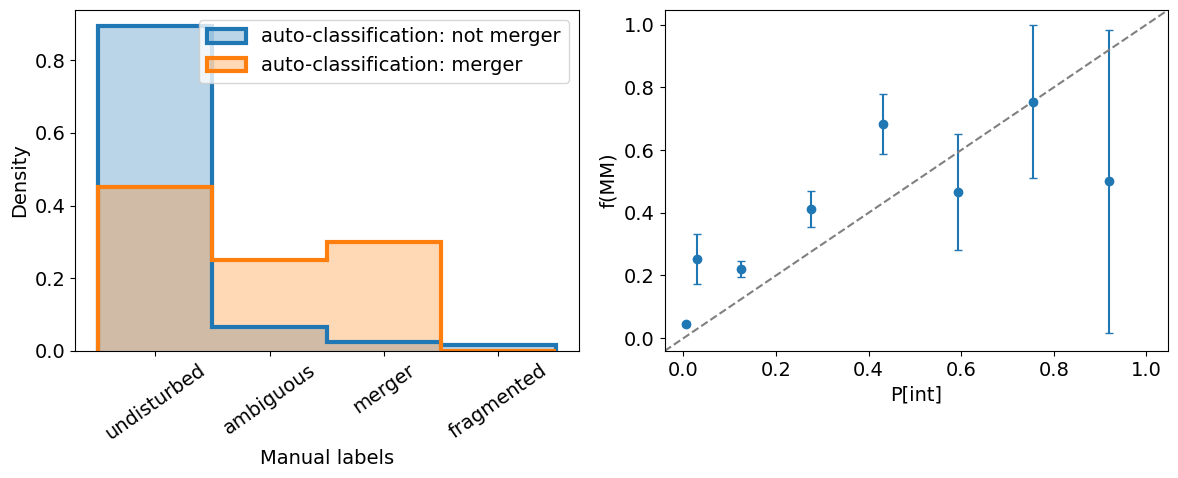

In [226]:
fig, axarr = plt.subplots(1, 2, figsize=(12,5))

ax = axarr[0]
# Compare with manual labels
if (labels > 0).any():    
    # Create contingency table
    manual_merger = (labels == 3) | (labels == 2)  # merger or ambiguous
    manual_nonmerger = labels == 1  # undisturbed
    
    hist_kwargs = {'alpha': 0.3, 'lw': 3, 'bins': np.arange(0.5, 5.5), 'density': True}
    
    ek.hist(labels[is_undisturbed], ax=ax, label='auto-classification: not merger', **hist_kwargs)
    ek.hist(labels[is_merger], ax=ax, label='auto-classification: merger', **hist_kwargs)
    
    ax.set_xticks(np.arange(1,5),['undisturbed', 'ambiguous', 'merger', 'fragmented'], rotation=35)
    ax.set_xlabel('Manual labels')
    ax.set_ylabel('Density')
    ax.legend()

ftp = sampling.classfraction(
    pmerger[manual_merger],
    pmerger[manual_nonmerger],
    add=True,
    alpha=0.16,
    bins=np.concatenate([[0., 0.01], np.linspace(0.05, 0.35,3), np.linspace(0.35, 1., 5)[1:]])
)
ek.errorbar(
    sampling.midpts(ftp[0]),
    np.mean(ftp[2], axis=0),
    ylow=ftp[2][0],
    yhigh=ftp[2][1],
    ax=axarr[1],
    capsize=3
)
axarr[1].set_xlabel('P[int]')
axarr[1].set_ylabel('f(MM)')
ek.oneone(axarr[1])
plt.tight_layout()
#axarr[1].set_xscale('log')

In [57]:
pthresh = 0.4

human_mrate = (((labels==3)|(labels==2))&(~fragmented)&has_autolabel).sum() / ((~fragmented)&has_autolabel).sum()
machine_mrate = np.sum(pmerger[~fragmented&has_autolabel]) / ((~fragmented)&has_autolabel).sum()


In [142]:
machine_mrate, human_mrate

(0.01773426166693211, 0.011195657441961906)

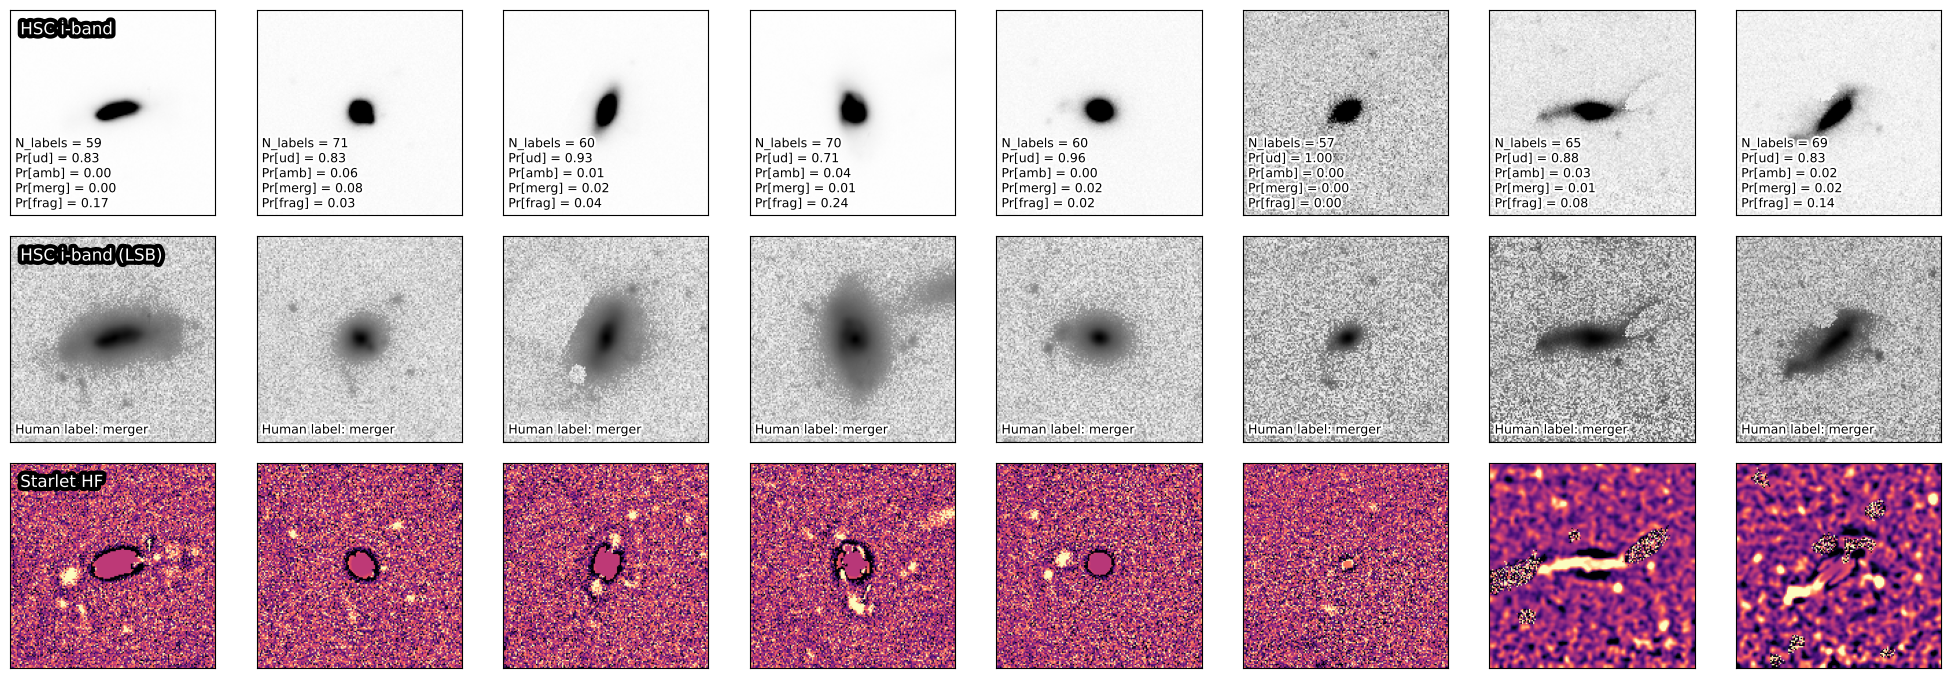

In [94]:
# Show examples of merger candidates
candidates = np.arange(len(img_names))[ (pmerger<0.4) & ~fragmented & (labels==3) & has_autolabel]
n_examples = min(8, len(candidates))

np.random.seed(32)
if n_examples > 0:
    example_indices = np.random.choice(candidates, n_examples, replace=False)
    
    fig, axarr = plt.subplots(3, n_examples, figsize=(n_examples*2.5, 7))
    
    for idx, gix in enumerate(example_indices):
        # Load this specific image on-demand
        img_name = img_names[gix]
        image = load_image_by_name(img_name, data_path)
        
        # i-band
        ek.imshow(image[1], ax=axarr[0, idx], q=0.01, cmap='Greys')
        
        # i-band log scale
        axarr[1, idx].imshow(
            image[1],
            origin='lower',
            cmap='Greys',
            norm=colors.SymLogNorm(linthresh=0.1)
        )
        
        # High-frequency
        ek.imshow(image[2], ax=axarr[2, idx], cmap='magma')
        
        # Add statistics
        ek.text(
            0.025, 0.025,
            f"""N_labels = {n_labels_iter[gix]}
Pr[ud] = {prob_labels_iter[gix, 1]:.2f}
Pr[amb] = {prob_labels_iter[gix, 2]:.2f}
Pr[merg] = {prob_labels_iter[gix, 3]:.2f}
Pr[frag] = {prob_labels_iter[gix, 4]:.2f}""",
            ax=axarr[0, idx],
            fontsize=9,
            bordercolor='w',
            color='k',
            borderwidth=3
        )
        ek.text(
            0.025,
            0.025,
            f'Human label: {label_meanings[labels[gix]]}',
            ax=axarr[1, idx],
            fontsize=9,
            bordercolor='w',
            color='k',
            borderwidth=3
        )            
    
    for ax in axarr.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    ek.text(0.05, 0.95, 'HSC i-band', ax=axarr[0, 0], fontsize=12, 
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'HSC i-band (LSB)', ax=axarr[1, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'Starlet HF', ax=axarr[2, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    
    plt.tight_layout()
else:
    print("No merger classification conflicts found")

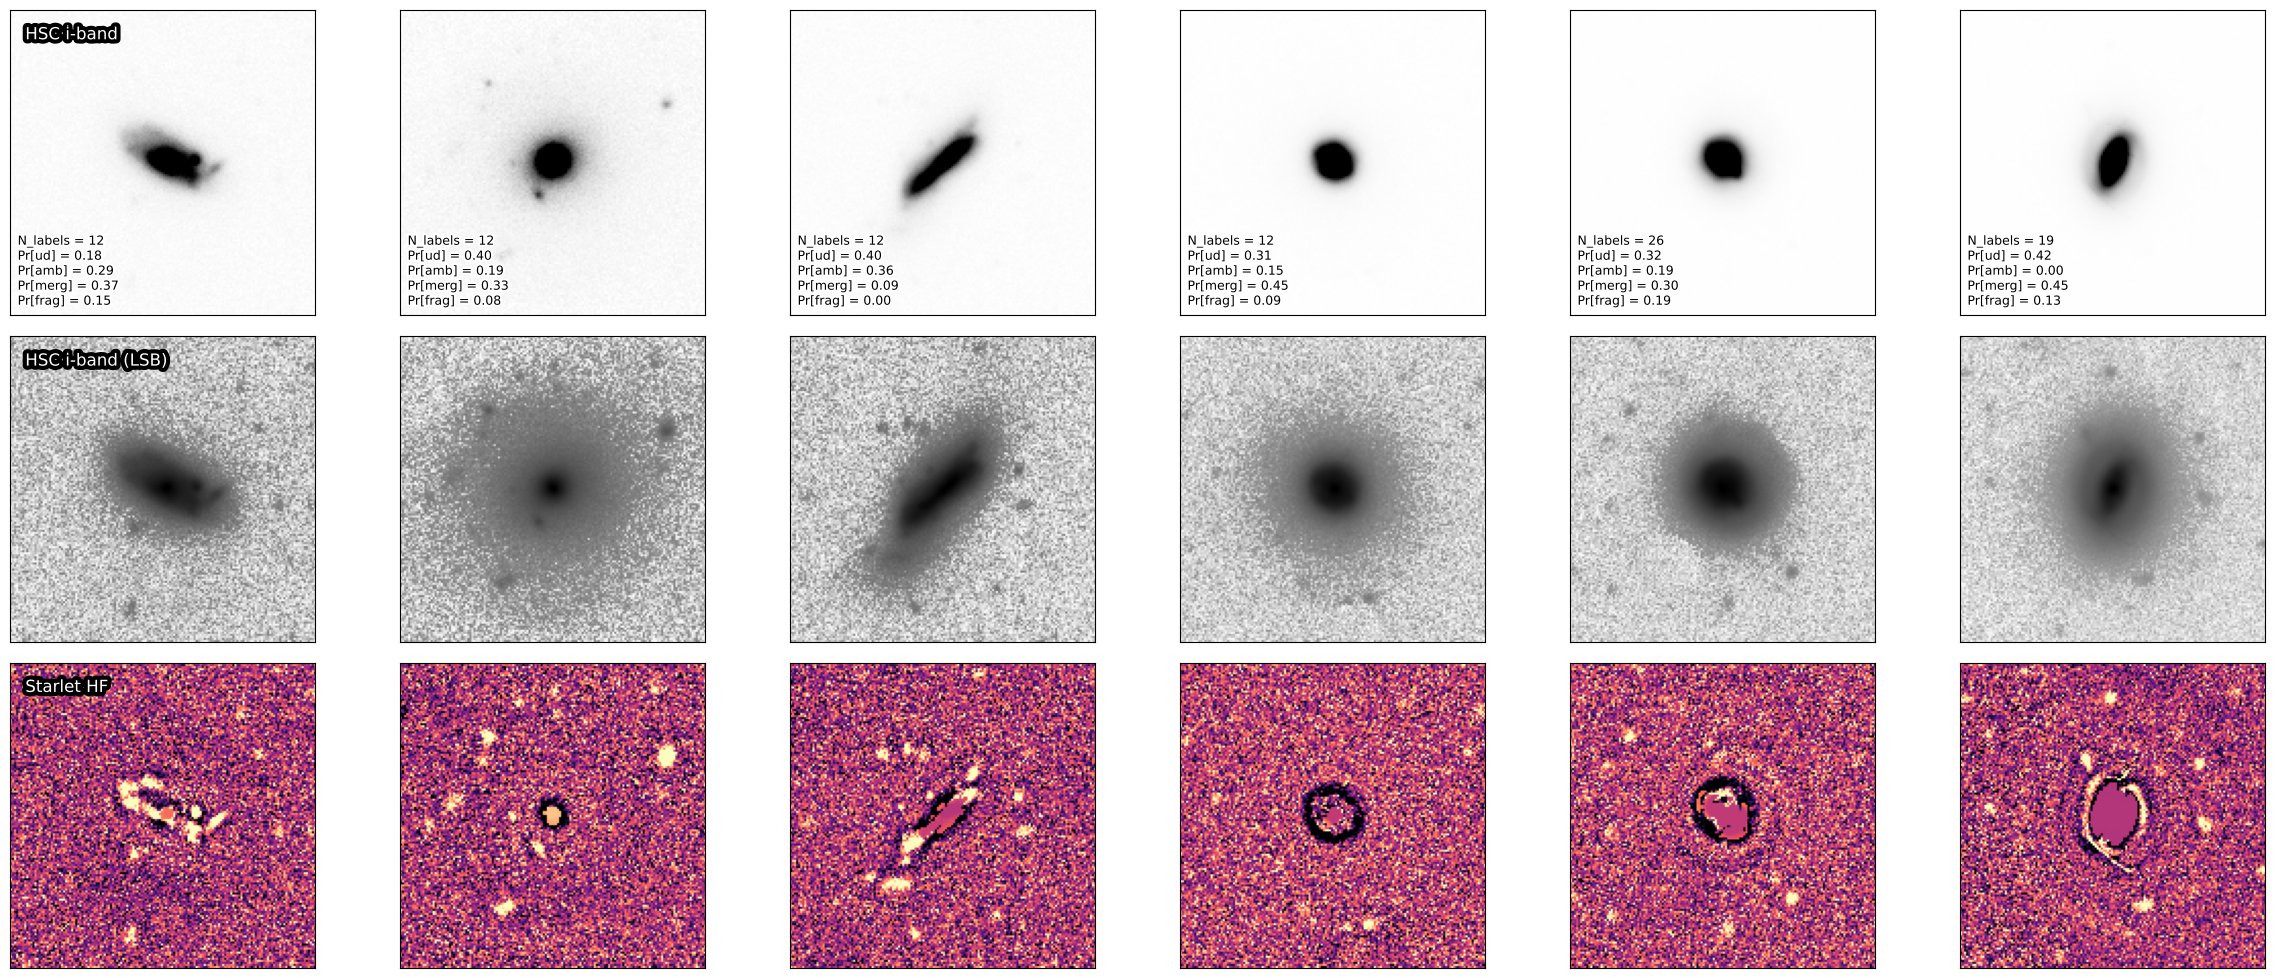

In [53]:
# Show examples of merger candidates
candidates = np.arange(len(img_names))[possible_merger & ~fragmented]
n_examples = min(6, len(candidates))

if n_examples > 0:
    example_indices = np.random.choice(candidates, n_examples, replace=False)
    
    fig, axarr = plt.subplots(3, n_examples, figsize=(4*n_examples, 10))
    
    for idx, gix in enumerate(example_indices):
        # Load this specific image on-demand
        img_name = img_names[gix]
        image = load_image_by_name(img_name, data_path)
        
        # i-band
        ek.imshow(image[1], ax=axarr[0, idx], q=0.01, cmap='Greys')
        
        # i-band log scale
        axarr[1, idx].imshow(
            image[1],
            origin='lower',
            cmap='Greys',
            norm=colors.SymLogNorm(linthresh=0.1)
        )
        
        # High-frequency
        ek.imshow(image[2], ax=axarr[2, idx], cmap='magma')
        
        # Add statistics
        ek.text(
            0.025, 0.025,
            f"""N_labels = {n_labels_iter[gix]}
Pr[ud] = {prob_labels_iter[gix, 1]:.2f}
Pr[amb] = {prob_labels_iter[gix, 2]:.2f}
Pr[merg] = {prob_labels_iter[gix, 3]:.2f}
Pr[frag] = {prob_labels_iter[gix, 4]:.2f}""",
            ax=axarr[0, idx],
            fontsize=9,
            bordercolor='w',
            color='k',
            borderwidth=3
        )
    
    for ax in axarr.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    ek.text(0.05, 0.95, 'HSC i-band', ax=axarr[0, 0], fontsize=12, 
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'HSC i-band (LSB)', ax=axarr[1, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'Starlet HF', ax=axarr[2, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    
    plt.tight_layout()
    plt.show()
else:
    print("No merger candidates found")

# Distance off MS

In [15]:
from ekfplot import colors as ec, plot as ek
from ekfphys import calibrations
from pieridae.starbursts import sample

In [16]:
full_catalog, masks = sample.load_sample(
    '/Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet'
)

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.5 seconds.
Computed internal extinction corrections in 0.6 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
full_catalog.loc[masks['is_good'][0]&masks['is_alosbms'][0]][['RA','DEC']].to_csv('../../../pixel_excess/local_data/alosbms_v0.txt',
                                                                                 index=False, header=False, sep=' ')

In [18]:
os.path.abspath('../../../pixel_excess/local_data/alosbms_v0.txt')

'/Users/kadofong/work/projects/merian/pixel_excess/local_data/alosbms_v0.txt'

In [19]:
full_catalog, masks = sample.load_sample(
    '/Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet'
)
base_catalog = full_catalog.loc[masks['is_good'][0]]

datadir = '../../local_data/pieridae_output/starlet/msorabove_v0/'
for sid in tqdm(base_catalog.index):
    filename = f'{datadir}/{sid}/{sid}_i_results.pkl'
    if not os.path.exists(filename):
        continue
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    base_catalog.loc[sid, 'logmass_adjusted'] = x['logmass_adjusted']
base_catalog.loc[base_catalog['logmass_adjusted'].isna(),'logmass_adjusted'] = base_catalog.loc[base_catalog['logmass'].isna(),'logmass_adjusted']

fragmented = prob_labels_iter[:,4] > 0.3
prob_merger = (prob_labels_iter[:,2]+prob_labels_iter[:,3]) > prob_labels_iter[:,1]

catalog = base_catalog.reindex(img_names[~fragmented])
catalog['p_merger'] = np.where((prob_labels_iter[~fragmented]==0).all(axis=1), np.nan, prob_labels_iter[~fragmented,3])
catalog['p_ambig'] = np.where((prob_labels_iter[~fragmented]==0).all(axis=1), np.nan, prob_labels_iter[~fragmented,2])
catalog['p_undisturbed'] = np.where((prob_labels_iter[~fragmented]==0).all(axis=1), np.nan, prob_labels_iter[~fragmented,1])

dm = catalog['logmass_adjusted'] - catalog['logmass']
catalog = catalog.loc[(dm < 0.5)&(catalog['logmass_adjusted']<=10.5)&(catalog['logmass_adjusted']>=7.5)]

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.5 seconds.
Computed internal extinction corrections in 0.6 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|                                                 | 0/54859 [00:00<?, ?it/s]/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_26422/226961955.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

/Users/kadofong/work/ekfutils/ekfplot/ekfplot/plot.py:494: RuntimeWarning: invalid value encountered in divide
  im=ax.pcolormesh(bins[0], bins[1], (weighted_counts/raw_counts).T, cmap=cmap, **kwargs)


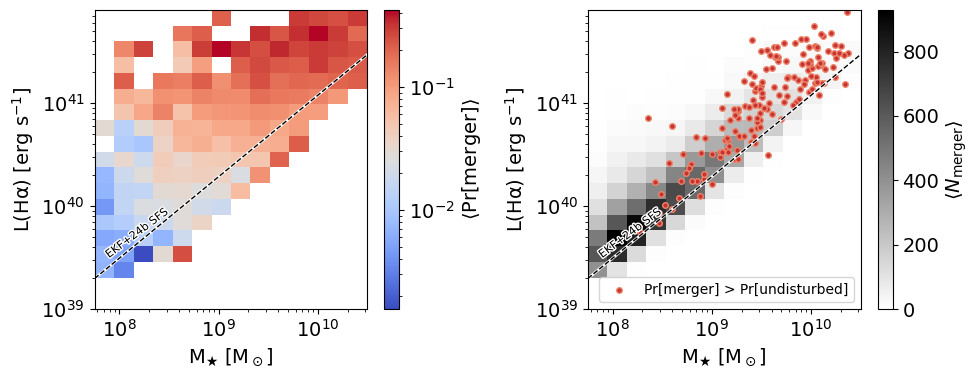

In [20]:
fig, axarr = plt.subplots(1,2,figsize=(10,4))

bins = [np.logspace(7.75, 10.5,15), np.logspace(39,41.9,20)]
im,_=ek.pcolor_avg2d(
    10.**catalog['logmass_adjusted'], 
    catalog['L_Ha'],
    catalog['p_merger']+catalog['p_ambig'],
    cmap='coolwarm',
    yscale='log',
    xscale='log',
    zscale='log',
    bins=bins,
    ax=axarr[0],
    #vmax=0.35,
    #vmin=0.01
    #s=3,
    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
)

imx=ek.hist2d(
    10.**catalog['logmass_adjusted'], 
    catalog['L_Ha'],
    cmap=ec.ColorBase('k').sequential_cmap(fade=1.),
    yscale='log',
    xscale='log',
    #zscale='log',
    bins=bins,
    ax=axarr[1],
    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
)

#imx=ek.hist2d(
#    10.**catalog['logmass_adjusted'], 
#    catalog['L_Ha'],
#    weights=np.where(np.isnan(catalog['p_merger']+catalog['p_ambig']),0., catalog['p_merger']+catalog['p_ambig']),
#    cmap=ec.ColorBase('tab:red').sequential_cmap(fade=0.),
#    yscale='log',
#    xscale='log',
#    #zscale='log',
#    bins=bins,
#    ax=axarr[1],
#    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
#)
probable_merger = (catalog['p_ambig']+catalog['p_merger'])>catalog['p_undisturbed']
axarr[1].scatter(
    10.**catalog.loc[probable_merger,'logmass_adjusted'], 
    catalog.loc[probable_merger, 'L_Ha'],
    fc=plt.cm.coolwarm(.95),
    ec=plt.cm.coolwarm(0.8),
    s=4**2,
    label=r'Pr[merger] > Pr[undisturbed]'
)
axarr[1].legend(loc='lower right', fontsize=10)

ms = im._coordinates.data[0,:,0]
alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs = 10.**(alpha*(np.log10(ms) - 8.5) + norm)
ha_sfs = calibrations.SFR2LHa(sfs)
plt.colorbar(imx[0][-1],ax=axarr[1], label=r'$\langle N_{\rm merger} \rangle$')
plt.colorbar(im,ax=axarr[0], label=r'$\langle {\rm Pr[merger]}\rangle$')

for ax in axarr:
    ek.outlined_plot(
        ms,
        ha_sfs,
        ax=ax,
        lw=1,
        ls='--',
    )
    
    ek.text(
        7e7,
        3e39,
        'EKF+24b SFS',
        ax=ax,
        rotation=37,
        coord_type='absolute',
        va='bottom',
        ha='left',
        bordercolor='w',
        borderwidth=2,
        fontsize=8,        
    )    
    ax.set_xlabel(ek.common_labels['mstar'])
    ax.set_ylabel(ek.common_labels['halum'])
    ek.loglog(ax=ax)

#prob_merger = (catalog['p_merger']+catalog['p_ambig']) > catalog['p_undisturbed']
#axarr[0].scatter(
#    10.**catalog.loc[prob_merger, 'logmass_adjusted'],
#    catalog.loc[prob_merger, 'L_Ha'],
#    color='lime'
#)
plt.tight_layout ()
if False:
    plt.savefig('/Users/kadofong/work/papers/journal/MerianStarbursts/figures/pmerger_sfs.pdf')

In [119]:
sfs_std

0.3976

In [122]:
calibrations.LHa2SFR(1e39)

0.0055

In [124]:

alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs_at_mass = 10.**(alpha*(catalog['logmass_adjusted'] - 8.5) + norm)
ha_sfs_at_mass = calibrations.SFR2LHa(sfs_at_mass)
sfs_std = 0.22*0.08 + 0.38
sfs = lambda logmstar: alpha*(logmstar-8.5) + norm

In [437]:
dsfs = np.log10(calibrations.LHa2SFR(catalog['L_Ha'])) - sfs(catalog['logmass_adjusted']) 
mask = abs(dsfs/sfs_std) < 0.2

out_baseline = sampling.running_metric(
    catalog.loc[mask, 'logmass_adjusted'],
    pmerger.loc[mask],
    np.nanmean,
    np.linspace(7., 10.25, 12),
    erronmetric=True
)

out_highconf = sampling.running_metric(
    catalog.loc[mask, 'logmass_adjusted'],
    (pmerger>catalog['p_undisturbed']).loc[mask],
    np.nanmean,
    np.linspace(7., 10.25, 8),
    erronmetric=True
)
pmerger_baseline_by_mass = lambda logmstar: np.interp(logmstar, out_baseline[0].flatten(),out_baseline[1][:,0,2].flatten())

/Users/kadofong/work/ekfutils/ekfstats/ekfstats/sampling.py:583: RuntimeWarning: Mean of empty slice
  outcome = metric_fn ( ypull[mask] )
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Merger detection fraction')

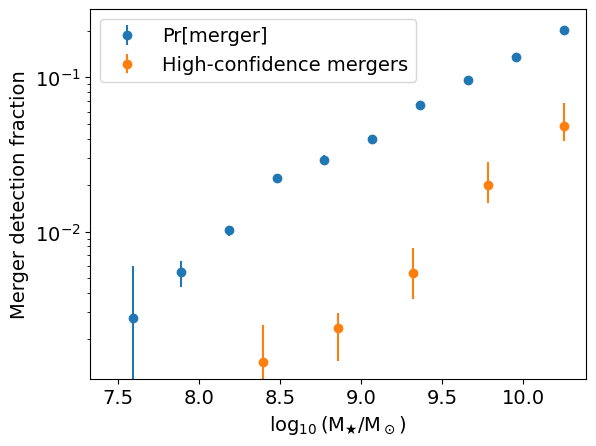

In [443]:
ek.errorbar(
    out_baseline[0].flatten(),
    out_baseline[1][:,0,2].flatten(),
    ylow=out_baseline[1][:,0,1],
    yhigh=out_baseline[1][:,0,3],
    label=r'Pr[merger]'
)
ek.errorbar(
    out_highconf[0].flatten(),
    out_highconf[1][:,0,2].flatten(),
    ylow=out_highconf[1][:,0,1],
    yhigh=out_highconf[1][:,0,3],
    label='High-confidence mergers'
)
plt.legend()
plt.yscale('log')
plt.xlabel(ek.common_labels['logmstar'])
plt.ylabel('Merger detection fraction')

In [369]:
_,ys,_ = sampling.running_metric(            
    np.log10(calibrations.LHa2SFR(selected['L_Ha'])) - ms_at_mass,
    pmerger.reindex(selected.index),
    np.nanmean,
    sampling.midpts(loglhabins),
    erronmetric=True
)

/Users/kadofong/work/ekfutils/ekfstats/ekfstats/sampling.py:569: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xpull = x[choice]
/Users/kadofong/work/ekfutils/ekfstats/ekfstats/sampling.py:583: RuntimeWarning: Mean of empty slice
  outcome = metric_fn ( ypull[mask] )
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [378]:
assns,loglhabins = sampling.bin_by_count(np.log10(calibrations.LHa2SFR(selected['L_Ha'])) - ms_at_mass, 10, 0.25)

/Users/kadofong/work/ekfutils/ekfstats/ekfstats/sampling.py:949: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_x = x[sortmask]


In [389]:
selected = catalog.loc[groups==gid]
dsfs = np.log10(calibrations.LHa2SFR(selected['L_Ha'])) - ms_at_mass
assns,loglhabins = sampling.bin_by_count(dsfs, 10, 0.25)
xs = sampling.midpts(loglhabins)/sfs_std

/Users/kadofong/work/ekfutils/ekfstats/ekfstats/sampling.py:949: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_x = x[sortmask]


In [407]:
logmstar_bins

[6, 8.5, 8.9, 9.3, 9.700000000000001, 12]

(array([3, 1, 1, ..., 1, 1, 1]),
 array([ 8.3991803 ,  8.7991803 ,  9.1991803 ,  9.5991803 ,  9.9991803 ,
        10.49614717]))

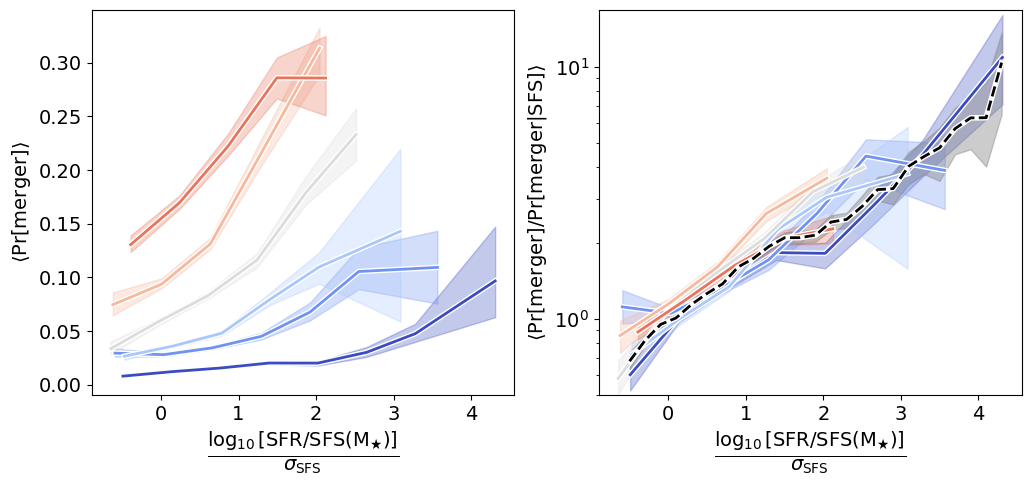

In [417]:
fig, axarr = plt.subplots(1,2,figsize=(12,5))

loglhabins = np.arange(-0.5,2.5, 0.25) 

#groups, logmstar_bins = sampling.bin_by_count(catalog['logmass_adjusted'], 3000, dx_min=0.25)
#logmstar_bins = [6] + list(sampling.bin_by_count(catalog['logmass_adjusted'][catalog.logmass_adjusted>8.4], 750, 0.4)[1]) + [12]
logmstar_bins = [6] + list(np.arange(8.5, 10.,0.3)) + [12]
groups = np.digitize(catalog['logmass_adjusted'], logmstar_bins)
groupids = np.unique(groups,)

for gidx,gid in enumerate(groupids):
    
    
    for idx,is_normalized in enumerate([False,True]):
        selected = catalog.loc[groups==gid]
        ms_at_mass = sfs(selected['logmass_adjusted'])
        dsfs = np.log10(calibrations.LHa2SFR(selected['L_Ha'])) - ms_at_mass
        assns,loglhabins = sampling.bin_by_count(dsfs, 10, 0.25)
        xs = sampling.midpts(loglhabins)/sfs_std

        if is_normalized:
            factor = 1./pmerger_baseline_by_mass(selected['logmass_adjusted'])
        else:
            factor = 1.
        
        _,ys,_ = sampling.running_metric(            
            dsfs,
            pmerger.reindex(selected.index)*factor,
            np.nanmean,
            sampling.midpts(loglhabins),
            erronmetric=True
        )

        
        ek.outlined_plot(
            xs,
            ys[:,0,2],
            lw=2,
            ax=axarr[idx],
            color=plt.cm.coolwarm(gidx/len(groupids))
        )
        axarr[idx].fill_between(
            xs,
            ys[:,0,1],
            ys[:,0,3],        
            label=f'[{logmstar_bins[gid-1]:.2f},{logmstar_bins[gid]:.2f}]',
            alpha=0.3,
            color=plt.cm.coolwarm(gidx/len(groupids))
        )        


xs = (np.log10(calibrations.LHa2SFR(catalog['L_Ha'])) - sfs(catalog['logmass_adjusted']))/sfs_std
ys = pmerger/pmerger_baseline_by_mass(catalog['logmass_adjusted'])
out = sampling.running_metric(xs,ys,np.nanmean, np.arange(-0.5,4.5,0.2), dx=0.4, erronmetric=True)
axarr[1].fill_between(
    out[0],
    out[1][:,0,1], 
    out[1][:,0,3], 
    color='grey',
    alpha=0.4,
)
ek.outlined_plot(
    out[0],
    out[1][:,0,2],
    ax=axarr[1],
    ls='--',
    lw=2
)

for ax in axarr:
    ax.set_xlabel(r'$ \frac{\log_{10}[{\rm SFR}/{\rm SFS(M_\bigstar)}]}{\sigma_{\rm SFS}}$', fontsize=20)
axarr[0].set_ylabel(r'$\langle \rm Pr[merger] \rangle$')
axarr[1].set_ylabel(r'$\langle \rm Pr[merger]/Pr[merger|SFS] \rangle$')
axarr[1].set_ylim(0.5,axarr[1].get_ylim()[-1])

#axarr[0].set_yscale('log')
axarr[1].set_yscale('log')
if False:
    plt.savefig('/Users/kadofong/Downloads/pmerge_v_mass.pdf')

In [108]:
from ekfplot import colorlists

In [109]:
hamorph = pd.read_csv('../../local_data/abby_morphology_statistics.csv', index_col=0)

In [110]:
hamorph['halpha_m20'] = np.where(hamorph['halpha_m20']<-3, np.nan, hamorph['halpha_m20'])
hamorph['continuum_m20'] = np.where(hamorph['continuum_m20']<-3, np.nan, hamorph['continuum_m20'])

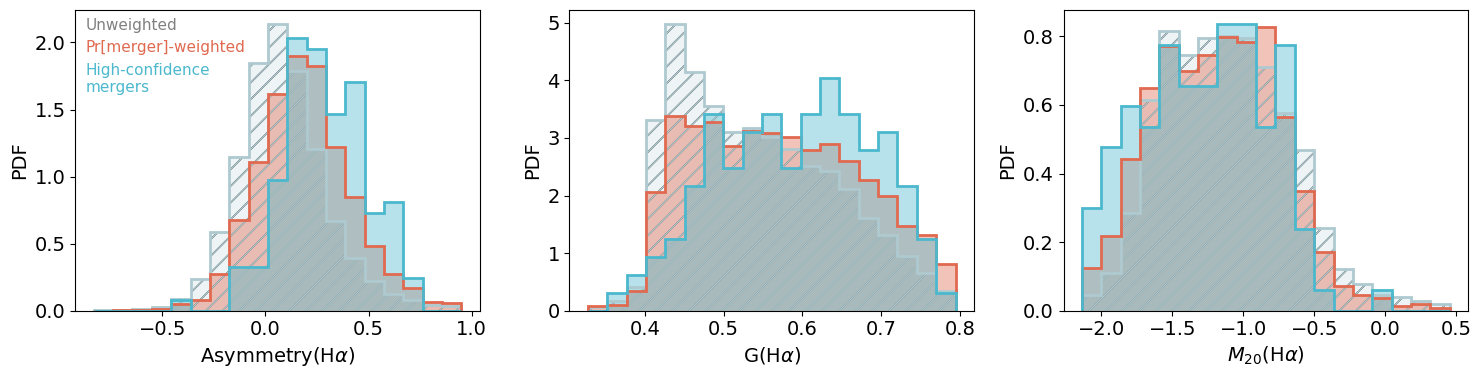

In [239]:
pmerger = catalog['p_merger']+catalog['p_ambig']

fig, faxarr = plt.subplots(1,3,figsize=(15,4))
faxarr = [faxarr]

tags = {'continuum':'continuum','halpha':r'H$\alpha$'}
labels = ['Asymmetry',r'G',r'$M_{20}$']
keys = ['asymmetry','gini','m20']

for adx,prefix in enumerate(['halpha']):
    axarr = faxarr[adx]
    
    for idx,key in enumerate(keys):
        morph_key = f'{prefix}_{key}'
        out=ek.hist(
            hamorph.reindex(catalog.index)[morph_key],
            density=True,
            alpha=0.2,
            lw=2,
            color=ec.ColorBase(colorlists.slides['blue']).modulate(0.2,-0.3).base,
            hatch='//',
            label='Unweighted',
            ax=axarr[idx],
            binalpha=0.005
        )
        bins = out[1][1]
        ek.hist(
            hamorph.reindex(catalog.index)[morph_key],
            weights=pmerger,
            density=True,
            alpha=0.4,
            lw=2.,
            color=colorlists.slides['red'],
            label='Weighted by Pr[interaction]',
            ax=axarr[idx],
            bins=bins
        )
        ek.hist(
            hamorph.reindex(catalog.loc[(pmerger>catalog['p_undisturbed'])].index)[morph_key],
            density=True,
            alpha=0.4,
            lw=2,
            color=colorlists.slides['blue'],
            label='High-confidence mergers',
            ax=axarr[idx],
            bins=bins
        )
        if idx==0:
            ek.text(0.025,0.975,'Unweighted',color='grey', ax=axarr[idx], fontsize=11)
            ek.text(0.025,0.9,'Pr[merger]-weighted',color=colorlists.slides['red'], ax=axarr[idx], fontsize=11)
            ek.text(0.025,0.825,'''High-confidence
mergers''',color=colorlists.slides['blue'], ax=axarr[idx], fontsize=11)
        axarr[idx].set_xlabel(rf'{labels[idx]}({tags[prefix]})')
        axarr[idx].set_ylabel('PDF')
plt.tight_layout ()
plt.savefig('/Users/kadofong/work/papers/journal/MerianStarbursts/figures/hamorphology.pdf')
# show Gini - M20 space

In [240]:
lotza = np.array([[-3.0065789473684212, 0.3799999999999999],
                  [-1.6776315789473686, 0.56375]])
lotzb = np.array([[-3.0000000000000004, 0.75],
                  [-0.0065789473684203514, 0.33124999999999993]])


In [160]:
ek.pcolor_avg2d(
    hamorph.reindex(catalog.index)['continuum_m20'],
    hamorph.reindex(catalog.index)['continuum_gini'],
    pmerger,
    bins=[np.linspace(-2.5,-0.5,30),np.linspace(0.3,0.8,30)],
    cmap='coolwarm',
    vmin=0.,
    vmax=0.16
)
ek.density_contour(
    hamorph.reindex(catalog.index)['continuum_m20'],
    hamorph.reindex(catalog.index)['continuum_gini'],
    quantiles=[0.16,0.5,0.9,0.95, 0.975],
    colors='w'
)
#plt.scatter(
#    hamorph.reindex(catalog.loc[(pmerger>catalog['p_undisturbed'])].index)['continuum_m20'],
#    hamorph.reindex(catalog.loc[(pmerger>catalog['p_undisturbed'])].index)['continuum_gini'],
#    color='pink',
#    marker='x'
#)
ek.outlined_plot(lotza[:,0], lotza[:,1], ls=':', lw=1, color='grey')
ek.outlined_plot(lotzb[:,0], lotzb[:,1], ls=':', lw=1, color='grey')
plt.xlabel("M20")
plt.ylabel("Gini")
plt.xlim(-2.5,-0.5)
plt.ylim(0.3, 0.75)

NameError: name 'hamorph' is not defined

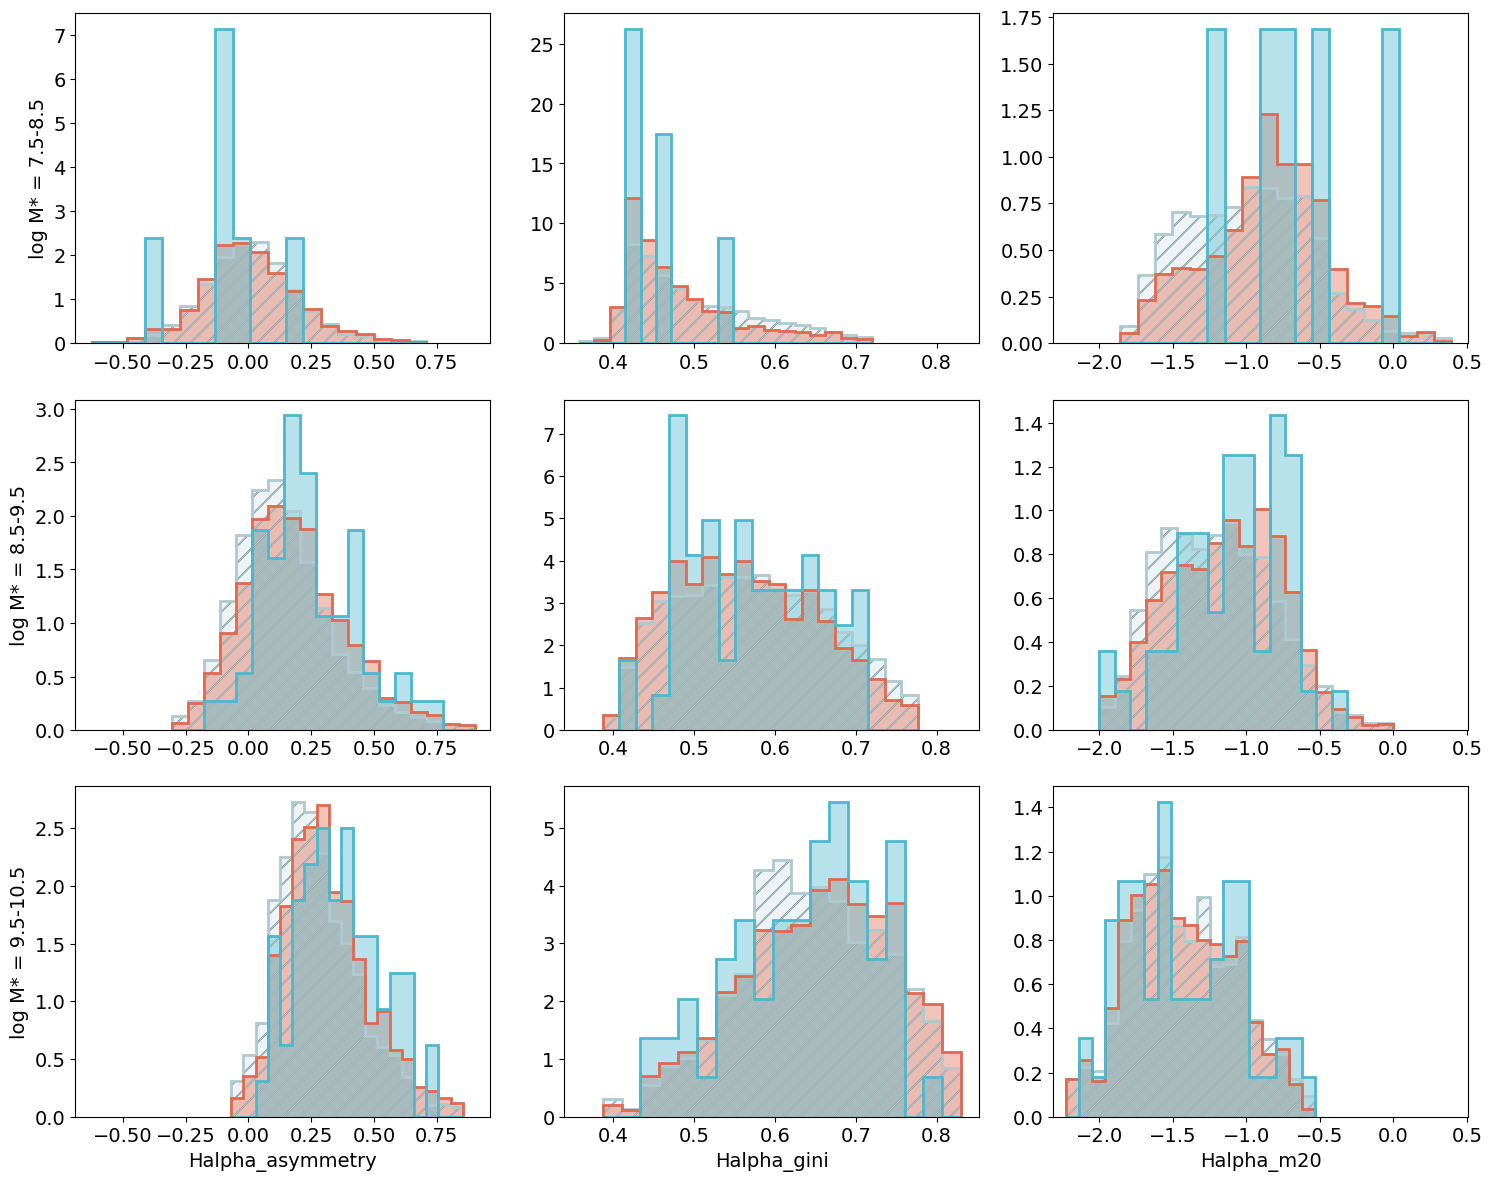

In [246]:
import numpy as np

pmerger = catalog['p_merger'] + catalog['p_ambig']

# Define mass bins
mass_bins = [7.5, 8.5, 9.5, 10.5]
mass_labels = ['7.5-8.5', '8.5-9.5', '9.5-10.5', '>10.5']

fig, axarr = plt.subplots(3, 3, figsize=(15, 12))
keys = ['halpha_asymmetry', 'halpha_gini', 'halpha_m20']

for row_idx in range(3):
    # Select galaxies in this mass bin
    mass_low = mass_bins[row_idx]
    mass_high = mass_bins[row_idx + 1]
    mass_mask = (catalog['logmass_adjusted'] >= mass_low) & (catalog['logmass_adjusted'] < mass_high)
    catalog_subset = catalog[mass_mask]
    
    for col_idx, morph_key in enumerate(keys):
        ax = axarr[row_idx, col_idx]
        
        # Unweighted histogram
        out = ek.hist(
            hamorph.reindex(catalog_subset.index)[morph_key],
            density=True,
            alpha=0.2,
            lw=2,
            color=ec.ColorBase(colorlists.slides['blue']).modulate(0.2, -0.3).base,
            hatch='//',
            ax=ax,
            binalpha=0.01
        )
        bins = out[1][1]
        
        # Weighted histogram
        ek.hist(
            hamorph.reindex(catalog_subset.index)[morph_key],
            weights=pmerger[mass_mask],
            density=True,
            alpha=0.4,
            lw=2.,
            color=colorlists.slides['red'],
            ax=ax,
            bins=bins
        )
        
        # High-confidence mergers
        high_conf_mask = mass_mask & (pmerger > catalog['p_undisturbed'])
        ek.hist(
            hamorph.reindex(catalog.loc[high_conf_mask].index)[morph_key],
            density=True,
            alpha=0.4,
            lw=2,
            color=colorlists.slides['blue'],
            ax=ax,
            bins=bins
        )
        
        # Labels
        if row_idx == 3:
            ax.set_xlabel(morph_key.capitalize())
        if col_idx == 0:
            ax.set_ylabel(f'log M* = {mass_labels[row_idx]}')

for idx in range(3):
    ek.sync_axis_limits(axarr[:,idx], 'x')
    axarr[-1,idx].set_xlabel(keys[idx].capitalize())

plt.tight_layout()

In [45]:
from astropy import coordinates, units as u
from astropy import cosmology 
from ekfstats import galstats
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [32]:
massive_galaxies = base_catalog.query('logmass_adjusted>10.')
mcoords = coordinates.SkyCoord(massive_galaxies['RA'],massive_galaxies['DEC'], unit='deg')
tcoords = coordinates.SkyCoord(catalog['RA'], catalog['DEC'], unit='deg')

nmc = 100

p_environment = np.zeros([nmc, len(catalog), 3])
for _ in tqdm(range(nmc)):
    #catalog['z'] = np.where(np.isnan(catalog['z_spec']), np.random.uniform(0.06, 0.1, len(catalog)), catalog['z_spec'])
    #massive_galaxies['z'] =  np.where(np.isnan(massive_galaxies['z_spec']), np.random.uniform(0.06, 0.1, len(massive_galaxies)), massive_galaxies['z_spec']) 
    catalog['z'] = np.where(np.isnan(catalog['z_spec']), 300., catalog['z_spec'])
    massive_galaxies['z'] =  np.where(np.isnan(massive_galaxies['z_spec']), 300., massive_galaxies['z_spec'])     
    envdict = galstats.classify_environment_fast(catalog, massive_galaxies, return_separations=False, verbose=0, vdiff_max_satellite=1000.)
    has_specz = np.isfinite(catalog['z_spec'])
    p_environment[_,:,0] = np.where(has_specz, envdict['satellite'], 0)
    p_environment[_,:,1] = np.where(has_specz, envdict['central'], 0)
    p_environment[_,:,2] = np.where(has_specz, envdict['isolated'], 0)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_99742/1390575908.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  massive_galaxies['z'] =  np.where(np.isnan(massive_galaxies['z_spec']), 300., massive_galaxies['z_spec'])
100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


In [109]:
import glob
from astropy import table
from astropy.io import fits

In [264]:
use_cached = True
cached_file = '../local_data/yue_meriansatellites_catalog/cached_catalog.csv'
if use_cached and os.path.exists(cached_file):
    yue = pd.read_csv(cached_file, index_col=0)
else:
    files = glob.glob('../local_data/yue_meriansatellites_catalog/*fits')
    yue = []
    for file in tqdm(files):
        satdata = table.Table(fits.getdata(file, 1)).to_pandas()
        yue.append(satdata)
    yue = pd.concat(yue)
    
    yue.index = [f'M{oid}' for oid in yue['objectId_Merian']]
    yue.to_csv(cached_file)    

lucas = pd.read_csv('../local_data/yue_meriansatellites_catalog/Merian_dwarf_hosts.csv')

lucas_trimmed = lucas[['objectId_Merian','coord_ra_Merian','coord_dec_Merian']]#.set_index('objectId_Merian')
lucas_trimmed.index = [f'M{oid}' for oid in lucas_trimmed['objectId_Merian']]

final_satellites = pd.concat([yue,lucas_trimmed])
final_satellites = final_satellites.loc[~final_satellites.index.duplicated()]

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_26422/1914345122.py:16: DtypeWarning: Columns (369,376,377,378,395,414,416,419,422,424,427,430) have mixed types. Specify dtype option on import or set low_memory=False.
  lucas = pd.read_csv('../local_data/yue_meriansatellites_catalog/Merian_dwarf_hosts.csv')


In [272]:
is_satellite = np.in1d(catalog.index, final_satellites.index)

/Users/kadofong/work/ekfutils/ekfstats/ekfstats/sampling.py:949: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_x = x[sortmask]
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_26422/3363898834.py:36: RuntimeWarning: All-NaN slice encountered
  ys = np.nanmedian(yarr,axis=0)[mask]
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


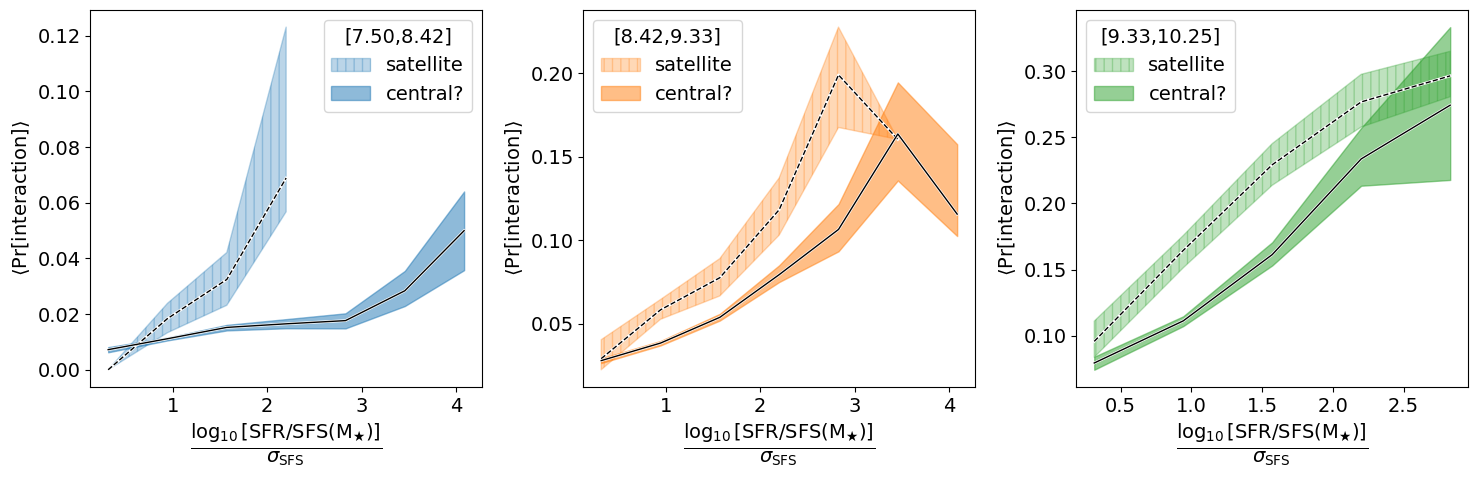

In [339]:
fig, axarr = plt.subplots(1,3,figsize=(15,5))

loglhabins = np.arange(0.,2.5, 0.25) 

groups, logmstar_bins = sampling.bin_by_count(catalog['logmass_adjusted'], 6000, dx_min=0.4)
logmstar_bins = np.linspace(7.5, 10.25, 4)
groups = np.digitize(catalog['logmass_adjusted'], logmstar_bins)

groupids = np.unique(groups,)
groupids = groupids[(groupids>0)&(groupids<len(logmstar_bins))]

ls_l = ['--','-',':']
for envkey in [0,1]:
    if envkey == 0:
        envmask = is_satellite
    elif envkey == 1:
        envmask = ~is_satellite
    for gidx,gid in enumerate(range(1, len(logmstar_bins))):
        ngal = (groups==gid).sum()
    
        nmc = 100
        xs = sampling.midpts(loglhabins)
        yarr = np.zeros([nmc, xs.size])
        for _ in range(nmc):
            selected = catalog.loc[(groups==gid)&envmask]
            selected = selected.iloc[np.random.randint(0, len(selected), len(selected))]
            ms_at_mass = sfs(selected['logmass_adjusted']) #np.interp ( selected['logmass_adjusted'], np.log10(ms), np.log10(ha_sfs) )
            assns = np.digitize(np.log10(calibrations.LHa2SFR(selected['L_Ha'])) - ms_at_mass, loglhabins)
        
            vals = pmerger.reindex(selected.index).groupby(assns)
            yarr[_] = np.nan
            yarr[_,vals.mean().index] = np.where(vals.count()>10, vals.mean().values, np.nan)
    
        mask = np.isfinite(yarr).any(axis=0)

        ys = np.nanmedian(yarr,axis=0)[mask]
        ys_low = np.nanquantile(yarr,0.16,axis=0)[mask]
        ys_high = np.nanquantile(yarr,0.84,axis=0)[mask]
            
        
        ek.outlined_plot(
            xs[mask]/sfs_std,
            ys,
            lw=1,
            ax=axarr[gidx],
            ls=ls_l[envkey],
        )
        axarr[gidx].fill_between(
            xs[mask]/sfs_std,
            ys_low,
            ys_high,        
            label= ['satellite','central?'][envkey], #f'[{logmstar_bins[gid-1]:.2f},{logmstar_bins[gid]:.2f}]',
            alpha=envkey==1 and 0.5 or 0.3,
            color=f'C{gidx}',
            hatch=envkey==0 and '||' or None,
        )


for gid,ax in enumerate(axarr):
    #ax.set_xlabel(r'$\log_{10}(L_{\rm H\alpha}/L_{\rm H\alpha}^{\rm SFS})$')
    ax.set_xlabel(r'$ \frac{\log_{10}[{\rm SFR}/{\rm SFS(M_\bigstar)}]}{\sigma_{\rm SFS}}$', fontsize=20)
    ax.legend(title=f'[{logmstar_bins[gid]:.2f},{logmstar_bins[gid+1]:.2f}]')
    ax.set_ylabel(r'$\langle \rm Pr[interaction] \rangle$')
    
plt.tight_layout ()
#plt.savefig('/Users/kadofong/Downloads/pmerge_v_env.png')

(<Axes: >,
 (array([0.16088214, 0.73029646, 0.76102675, 0.3868402 , 0.23861171,
         0.1120752 , 0.07411424, 0.0253073 , 0.00361533, 0.        ,
         0.00723066, 0.        ]),
  array([-0.5, -0.1,  0.3,  0.7,  1.1,  1.5,  1.9,  2.3,  2.7,  3.1,  3.5,
          3.9,  4.3]),
  [<matplotlib.patches.Polygon at 0x3478a3190>]))

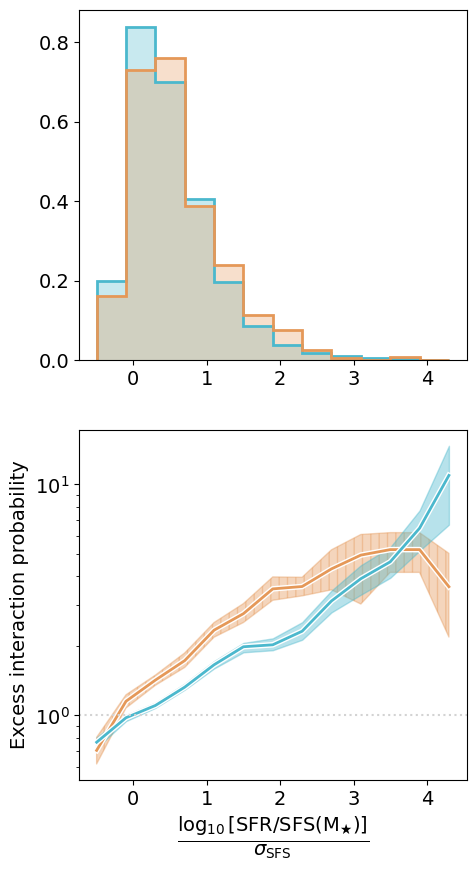

In [343]:
fig, axarr = plt.subplots(2,1,figsize=(5,10))


xs = (np.log10(calibrations.LHa2SFR(catalog['L_Ha'])) - sfs(catalog['logmass_adjusted']))/sfs_std
ys = pmerger/pmerger_baseline_by_mass(catalog['logmass_adjusted'])

ax = axarr[1]
for envkey in [0,1]:
    if envkey == 0:
        envmask = is_satellite
    elif envkey == 1:
        envmask = ~is_satellite
        
    out = sampling.running_metric(xs[envmask],ys[envmask],np.nanmean, np.arange(-0.5,4.5,0.4), dx=0.5, erronmetric=True)
    cc = [colorlists.slides['orange'], colorlists.slides['blue']][envkey]
    ax.fill_between(
        out[0],
        out[1][:,0,1], 
        out[1][:,0,3], 
        color=cc,
        alpha=0.4,
        hatch=envkey==0 and '||' or None,
    )
    ek.outlined_plot(
        out[0],
        out[1][:,0,2],
        ax=ax,
        color=cc,
        lw=2
    )

ax.set_xlabel(r'$ \frac{\log_{10}[{\rm SFR}/{\rm SFS(M_\bigstar)}]}{\sigma_{\rm SFS}}$', fontsize=20)
ax.set_ylabel(r'Excess interaction probability')
ax.axhline(1., color='lightgrey', ls=':')
ax.set_yscale('log')

ek.hist(xs[~is_satellite], density=True, alpha=0.3, lw=2, color=colorlists.slides['blue'], ax=axarr[0], bins=out[0])
ek.hist(xs[is_satellite], density=True, alpha=0.3, lw=2, color=colorlists.slides['orange'], ax=axarr[0], bins=out[0])
